In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def euribor_func(t, a, b, c, d):
    return a+(b-a)*np.exp(-(1.0/2.0)*((t-c)/(d/6.0))**2.0)
    
def mortgage_interest_func(euribor, margin,
                           interest_ceiling=None, interest_ceiling_base=None, interest_ceiling_length=None):
    interest = np.zeros_like(euribor)
    for i in range(euribor.shape[0]):
        if interest_ceiling is None or i > interest_ceiling_length:
            interest[i] = max(euribor[int(i/12)*12],0.0) + margin
        else:
            interest[i] = np.minimum(np.maximum(euribor[int(i/6)*6], interest_ceiling_base)+margin, interest_ceiling)
    return interest

def annual_interest_to_monthly(annual):
    return (1.0+annual/100)**(1.0/12.0)-1.0

def mortgage_initial_total_func(amount, length_months, interest_monthly):
    base = amount / length_months
    amount_left = amount
    x = 0.0
    for i in range(length_months):
        x += amount_left*interest_monthly[i] + base
        amount_left -= base
    return x

def downpayment_initial_func(amount, mortgage_monthly, interest_monthly):
    amount_left = amount
    downpay = np.zeros_like(mortgage_monthly)
    for i in range(mortgage_monthly.shape[0]):
        downpay[i] = mortgage_monthly[i]-amount_left*interest_monthly[i]
        amount_left -= downpay[i]
    return downpay

def mortgage_monthly_func(amount, downpayment_monthly, interest_monthly):
    amount_left = amount
    mortgage_monthly = np.zeros_like(downpayment_monthly)
    for i in range(mortgage_monthly.shape[0]):
        mortgage_monthly[i] = downpayment_monthly[i]+amount_left*interest_monthly[i]
        amount_left -= downpayment_monthly[i]
    return mortgage_monthly
    
def invest_func(n, base, growth_percentage):
    g = (1.0+growth_percentage/100)**(1.0/12)
    x = []
    x.append(base)
    for i in range(n-1):
        x.append(x[-1]*g + base)
    return np.array(x)

def simulate(amount, downpayment_monthly, interest_monthly, invest_growth_annual, budget):
    ig = (1.0+invest_growth_annual/100)**(1.0/12)
    invest = np.zeros_like(downpayment_monthly)
    amount_left = amount
    invest_saldo = 0.0
    for i in range(downpayment_monthly.shape[0]):
        mortgage_monthly = downpayment_monthly[i]+amount_left*interest_monthly[i]
        amount_left -= downpayment_monthly[i]
        inv = budget-mortgage_monthly
        #if interest_monthly[i] < ig-1.0: # only invest if interest is smaller than expected growth
        invest_saldo += inv
        #else: # otherwise, downpay the mortgage more
        #    amount_left -= inv
            
        #if mortgage_monthly > budget:
        #    invest_saldo -= mortgage_monthly-budget

        if invest_saldo > 0.0:
            invest_saldo *= ig
        invest[i] = invest_saldo
    return invest
    

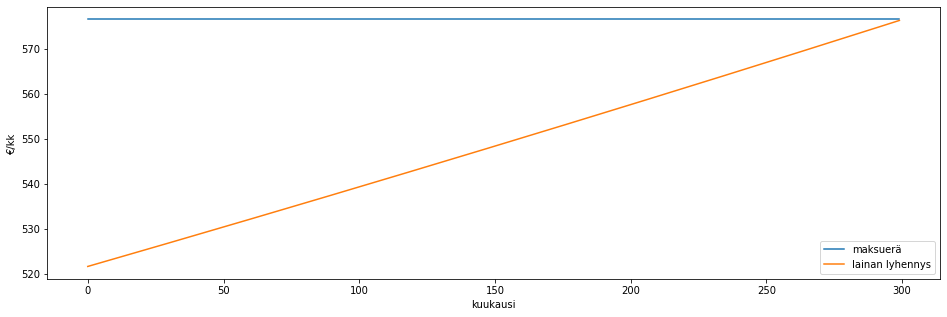

In [3]:
mortgage_amount = 164700
mortgage_length = 25 # years
mortgage_margin = 0.4 # %

length_months = mortgage_length*12
t = np.array([i for i in range(length_months)])
interest_monthly_initial = np.ones(length_months)*((1.0+(mortgage_margin/100.0))**(1.0/12.0)-1.0)
mortgage_total_initial = mortgage_initial_total_func(mortgage_amount, length_months, interest_monthly_initial)
mortgage_monthly_initial = np.ones(length_months)*(mortgage_total_initial / length_months)
downpayment_monthly = downpayment_initial_func(mortgage_amount, mortgage_monthly_initial, interest_monthly_initial)

fig, ax = plt.subplots(figsize=(16,5))
line_mortgage_monthly_initial, = ax.plot(t, mortgage_monthly_initial, label="maksuerä")
line_downpayment_monthly, = ax.plot(t, downpayment_monthly, label="lainan lyhennys")
ax.legend(handles=[line_mortgage_monthly_initial, line_downpayment_monthly])
ax.set_xlabel("kuukausi")
ax.set_ylabel("€/kk")
plt.show()

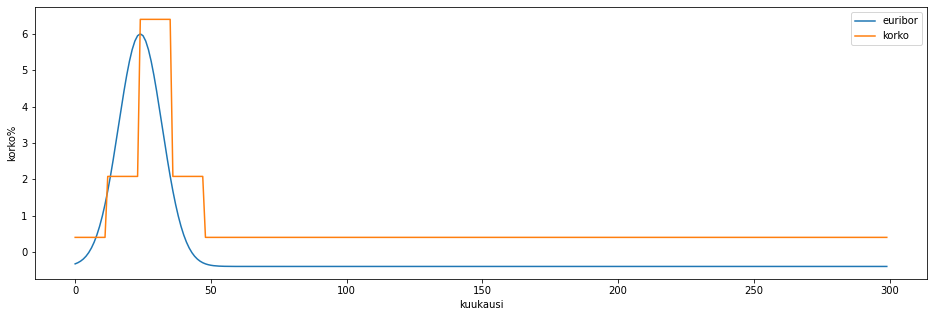

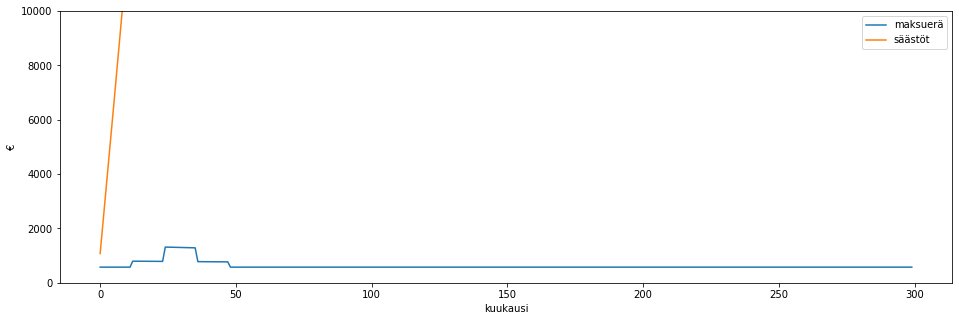

In [4]:
euribor_param_a = -0.4 # minimum euribor %
euribor_param_b = 6.0 # maximum euribor %
euribor_param_c = 2.0*12 # time of peak (months)
euribor_param_d = 4.0*12 # width of peak (months)
invest_growth_annual = 5.0 # invest return %
budget = 1650.0 # monthly budget

euribor = euribor_func(t, euribor_param_a, euribor_param_b, euribor_param_c, euribor_param_d)
euribor_monthly = annual_interest_to_monthly(euribor)
interest = mortgage_interest_func(euribor, mortgage_margin)
interest_monthly = annual_interest_to_monthly(interest)
mortgage_monthly = mortgage_monthly_func(mortgage_amount, downpayment_monthly, interest_monthly)
invest_saldo_monthly = simulate(mortgage_amount, downpayment_monthly, interest_monthly,
                                invest_growth_annual, budget)

fig, ax = plt.subplots(figsize=(16,5))
line_euribor, = ax.plot(t, euribor, label="euribor")
line_interest, = ax.plot(t, interest, label="korko")
ax.set_xlabel("kuukausi")
ax.set_ylabel("korko%")
ax.legend(handles=[line_euribor, line_interest])
fig, ax = plt.subplots(figsize=(16,5))
line_mortgage_monthly, = ax.plot(t, mortgage_monthly, label="maksuerä")
line_invest_saldo_monthly, = ax.plot(t, invest_saldo_monthly, label="säästöt")
ax.legend(handles=[line_mortgage_monthly, line_invest_saldo_monthly])
ax.set_xlabel("kuukausi")
ax.set_ylabel("€")
plt.ylim(0, 10000)
plt.show()

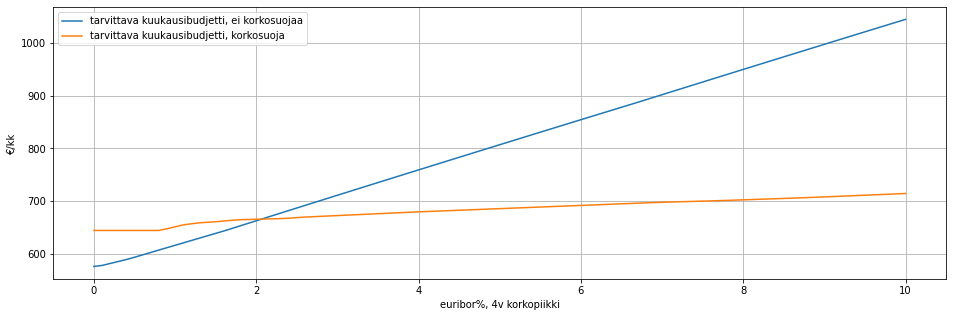

In [5]:
euribor_peak_table1 = []
euribor_peak_table2 = []
budget_table1 = []
budget_table2 = []
for i in range(0,101):
    epsilon = 0.001
    budget_search_increment = 100.0
    budget1 = 0.0
    j = 0
    while budget_search_increment > epsilon and j < 5000:
        euribor_param_a = -0.4 # minimum euribor %
        euribor_param_b = 0.1*i # maximum euribor %
        euribor_param_c = 5.0*12 # time of peak (months)
        euribor_param_d = 10.0*12 # width of peak (months)
        invest_growth_annual = 5.0 # invest return %
        budget1 += budget_search_increment # monthly budget

        euribor = euribor_func(t, euribor_param_a, euribor_param_b, euribor_param_c, euribor_param_d)
        euribor_monthly = annual_interest_to_monthly(euribor)
        interest = mortgage_interest_func(euribor, mortgage_margin)
        interest_monthly = annual_interest_to_monthly(interest)
        mortgage_monthly = mortgage_monthly_func(mortgage_amount, downpayment_monthly, interest_monthly)
        invest_saldo_monthly = simulate(mortgage_amount, downpayment_monthly, interest_monthly,
                                        invest_growth_annual, budget1)
        
        invest_saldo_min = min(invest_saldo_monthly)
        if invest_saldo_min > 0.0:
            budget1 -= budget_search_increment
            budget_search_increment /= 2.0
        j += 1
    
    budget_search_increment = 100.0
    budget2 = 0.0
    k = 0
    while budget_search_increment > epsilon and k < 5000:
        euribor_param_a = -0.4 # minimum euribor %
        euribor_param_b = 0.1*i # maximum euribor %
        euribor_param_c = 5.0*12 # time of peak (months)
        euribor_param_d = 10.0*12 # width of peak (months)
        invest_growth_annual = 5.0 # invest return %
        budget2 += budget_search_increment # monthly budget

        euribor = euribor_func(t, euribor_param_a, euribor_param_b, euribor_param_c, euribor_param_d)
        euribor_monthly = annual_interest_to_monthly(euribor)
        interest = mortgage_interest_func(euribor, mortgage_margin, 1.45, 0.5, 84)
        interest_monthly = annual_interest_to_monthly(interest)
        mortgage_monthly = mortgage_monthly_func(mortgage_amount, downpayment_monthly, interest_monthly)
        invest_saldo_monthly = simulate(mortgage_amount, downpayment_monthly, interest_monthly,
                                        invest_growth_annual, budget2)
        
        invest_saldo_min = min(invest_saldo_monthly)
        if invest_saldo_min > 0.0:
            budget2 -= budget_search_increment
            budget_search_increment /= 2.0
        k += 1
    
    if j < 5000:
        euribor_peak_table1.append(euribor_param_b)
        budget_table1.append(budget1)
    else:
        break
            
    if k < 5000:
        euribor_peak_table2.append(euribor_param_b)
        budget_table2.append(budget2)
    else:
        break

fig, ax = plt.subplots(figsize=(16,5))
line_required_budget1, = ax.plot(euribor_peak_table1, budget_table1, label="tarvittava kuukausibudjetti, ei korkosuojaa")
line_required_budget2, = ax.plot(euribor_peak_table2, budget_table2, label="tarvittava kuukausibudjetti, korkosuoja")
ax.legend(handles=[line_required_budget1, line_required_budget2])
ax.set_xlabel("euribor%, 4v korkopiikki")
ax.set_ylabel("€/kk")
plt.grid()
plt.show()

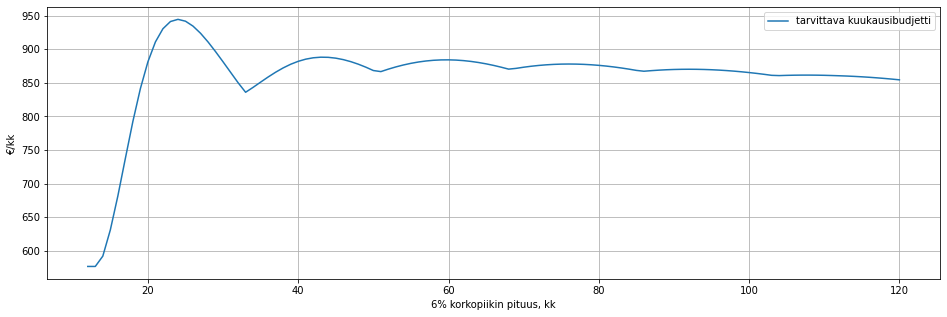

In [6]:
euribor_length_table = []
budget_table = []
for i in range(12,121):
    epsilon = 0.001
    budget_search_increment = 100.0
    budget = 0.0
    j = 0
    while budget_search_increment > epsilon and j < 5000:
        euribor_param_a = -0.4 # minimum euribor %
        euribor_param_b = 6.0 # maximum euribor %
        euribor_param_c = i/2.0 # time of peak (months)
        euribor_param_d = i # width of peak (months)
        invest_growth_annual = 5.0 # invest return %
        budget += budget_search_increment # monthly budget

        euribor = euribor_func(t, euribor_param_a, euribor_param_b, euribor_param_c, euribor_param_d)
        euribor_monthly = annual_interest_to_monthly(euribor)
        interest = mortgage_interest_func(euribor, mortgage_margin)
        interest_monthly = annual_interest_to_monthly(interest)
        mortgage_monthly = mortgage_monthly_func(mortgage_amount, downpayment_monthly, interest_monthly)
        invest_saldo_monthly = simulate(mortgage_amount, downpayment_monthly, interest_monthly,
                                        invest_growth_annual, budget)
        
        invest_saldo_min = min(invest_saldo_monthly)
        if invest_saldo_min > 0.0:
            budget -= budget_search_increment
            budget_search_increment /= 2.0
        j += 1
        
    if j < 5000:
        euribor_length_table.append(euribor_param_d)
        budget_table.append(budget)
    else:
        break

fig, ax = plt.subplots(figsize=(16,5))
line_required_budget, = ax.plot(euribor_length_table, budget_table, label="tarvittava kuukausibudjetti")
ax.legend(handles=[line_required_budget])
ax.set_xlabel("6% korkopiikin pituus, kk")
ax.set_ylabel("€/kk")
plt.grid()
plt.show()

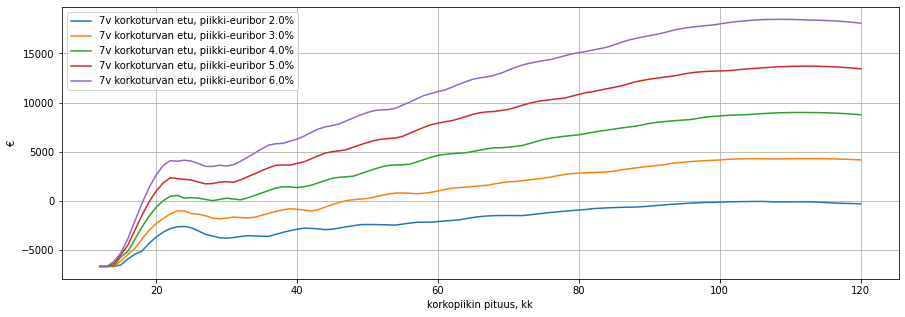

In [8]:
max_euribors = [2.0, 3.0, 4.0, 5.0, 6.0]
euribor_length_table = []
invest_10y_tables = {int(b) : [] for b in max_euribors}
for i in range(12,121):
    for euribor_param_b in max_euribors:
        euribor_param_a = -0.4 # minimum euribor %
        #euribor_param_b = 5.0 # maximum euribor %
        euribor_param_c = i/2.0 # time of peak (months)
        euribor_param_d = i # width of peak (months)
        invest_growth_annual = 5.0 # invest return %
        budget = 2000.0 # monthly budget

        t = np.array([i for i in range(length_months)])
        euribor = euribor_func(t, euribor_param_a, euribor_param_b, euribor_param_c, euribor_param_d)
        euribor_monthly = annual_interest_to_monthly(euribor)
        interest = mortgage_interest_func(euribor, mortgage_margin)
        interest_monthly = annual_interest_to_monthly(interest)
        mortgage_monthly = mortgage_monthly_func(mortgage_amount, downpayment_monthly, interest_monthly)
        invest_saldo_monthly = simulate(mortgage_amount, downpayment_monthly, interest_monthly,
                                        invest_growth_annual, budget)

        inv1 = invest_saldo_monthly[84]

        interest = mortgage_interest_func(euribor, mortgage_margin, 1.45, 0.5, 84)
        interest_monthly = annual_interest_to_monthly(interest)
        mortgage_monthly = mortgage_monthly_func(mortgage_amount, downpayment_monthly, interest_monthly)
        invest_saldo_monthly = simulate(mortgage_amount, downpayment_monthly, interest_monthly,
                                        invest_growth_annual, budget)

        inv2 = invest_saldo_monthly[84]
        #print(f"{inv1} {inv2} {inv2-inv1}")
        invest_10y_tables[int(euribor_param_b)].append(inv2-inv1)
    
    euribor_length_table.append(euribor_param_d)

fig, ax = plt.subplots(figsize=(15,5))
line_required_budgets = {int(b) : [] for b in max_euribors}
for b in max_euribors:
    line_required_budgets[int(b)], = ax.plot(euribor_length_table, invest_10y_tables[int(b)], label=f"7v korkoturvan etu, piikki-euribor {b}%")
ax.legend(handles=[h for _,h in line_required_budgets.items()])
ax.set_xlabel("korkopiikin pituus, kk")
ax.set_ylabel("€")
plt.grid()
plt.show()